In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted,realsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
!pwd

/home/ab2935/project/purity-monitor


In [3]:
plt.style.use('style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, 'WaveformAnalysis/')

In [5]:
LXe_Full_NEG109C_setpoint = '/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/'
LXe_Full_Source_Gain_after_0V='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Gain_after_0V/'
LXe_Full_Source_Removed_Gain_after_0V='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/'
LXe_Full_E_field_2kV_Gain='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/'
LXe_Full_E_field_2kV_source_reposition_Gain='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain/'
LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure/'
LXe_Full_E_field_2kV_Gain_source_removed='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/'
LXe_Full_E_field_NEG2kV_Gain_source_removed='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_Gain_source_removed/'
LXe_Full_E_field_NEG2kV_source_reposition_Gain_source_removed='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/'
LXe_Full_E_field_NEG2kV_source_gain_after='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_gain_after/'
LXe_Full_E_field_NEG2kV_LED_gain_after='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/'
LXe_Full_LED_gain_final='/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/'
# Path=LXe_Full_NEG109C_setpoint

Let's get the voltage steps from the filenames

In [6]:
def Voltages(Path):
    voltages = glob.glob(Path+'mca*')
    voltages = [x.split('_')[-2] for x in voltages]
    voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
    voltages = np.unique(voltages)
    # voltages=['3.50','4.00']
    return(voltages)

Now we can loop over all files for the various voltages, save the data and run a simple analysis including baseline subtraction and maximum finding

In [7]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [8]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [9]:
def line(x,a,b):
    return a*(x-b)

In [10]:
def gain_calculator(PATH,N_BINS,N_PEAKS):

    BINS=N_BINS #Number of bins to rebin the MCA data with
    N_peaks= N_PEAKS# Number o peaks to use for calculating the gain
    gain_list=[] #empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] #empty list to fill in the values of gain fit error, returned at the end of this function
    calib_pe=[]#empty list to fill in the values for calibrated PE 
    calib_count=[]
    Files = glob.glob(PATH+'*mca*.h5')
    #for loop to loop over all the files
    for i,file in enumerate(natsorted(Files)):
        print(file) 
    
    
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df[250:]
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)
        

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
        peaks,pdict=find_peaks(h,prominence=PROMINENCE)
        peak_length=len(peaks)
        #We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            
            peaks,pdict=find_peaks(h,prominence=PROMINENCE)
            peak_length=len(peaks)

        #To avoid fitting the pedestal, we ignore the first peak. In case the pedestal isn't there, then first peak gets ignored. This shouldn't change gain or BV calculation
        first_pe_max=hx[peaks[0]] # The x-value of the 3rd peak.Index=1 means the second peak will be used for getting fit parameters
        max_value=h[peaks[0]] # The height of the 3rd peak
        x_idx_array=(h<0.5*max_value) & (hx>first_pe_max)# returns a boolean array where both conditions are true
        right_side_x= hx[np.where(x_idx_array)[0][0]] #finding the first time where x_idx_array is True
        sigma_guess=np.abs(first_pe_max-right_side_x) #We need this to fit the width of the Gaussian peaks

       
        plt.figure(figsize=(12,2)) # Call the figure here
        plt.subplot(1,3,1) #This subplot will plot the position of the peaks and also the data
        plt.xlim(0,4000/BINS)
        # plt.ylim(0,50)
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.plot(hx,h,lw=1) #plot the signal
        cut= (hx < first_pe_max+sigma_guess) & (hx > first_pe_max-sigma_guess) # This cut helps to fix the width of the peak-fit
        popt,pcov=curve_fit(gauss,hx[cut],h[cut],p0=[max_value,first_pe_max,sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
        plt.plot(hx[cut],gauss(hx[cut],*popt),color='green',label='Fit',lw=2,alpha=0.5) # Here we plot the fit on the 2nd peak to see if everything looks ok.
        
        
            
        
        
        
        for i,peak in enumerate(peaks[2:]): #here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] #x-value of the peak
            new_max_value=h[peak] #height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] #finding the first time where x_idx_array is True
            new_sigma_guess=np.abs(new_first_pe_max-new_right_side_x) #We need this to fit the width of the Gaussian peaks


            new_cut= (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]) #Here we append the value of the peak fit mean 

        plt.subplot(1,3,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        # if (h[peaks[2]]/BINS<90): 
        #     popt_temp,pcov_temp=curve_fit(line,np.arange(3,len(peaks)+1),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
        #     plt.plot(np.arange(3,len(peaks)+1),line(np.arange(3,len(peaks)+1),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit

        #     plt.scatter(np.arange(3,len(peaks)+1),gain_temp,color='r') #plot the values of the peak means
        #     plt.legend(loc=2)
        # else:
        popt_temp,pcov_temp=curve_fit(line,np.arange(2,len(peaks)),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(2,len(peaks)),line(np.arange(2,len(peaks)),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        plt.scatter(np.arange(2,len(peaks)),gain_temp,color='r') #plot the values of the peak means
        plt.legend(loc=2)
  
        
        gain_list.append(popt_temp[0]) #append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) #append the straight line error fit

        calib_pe.append(hx/popt_temp[0]+popt_temp[1])
        calib_count.append(h)
        
        plt.subplot(1,3,3)#This subplot shows the calibrated PE spectra
        plt.plot(hx/popt_temp[0]+popt_temp[1],h)
        plt.yscale('log')
        plt.xlim(0,5)
        plt.xticks(np.arange(0,5))
        plt.grid()
        plt.show() #show the plot

    return(np.array(calib_pe),np.array(calib_count),np.array(gain_list),np.array(gain_err))

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


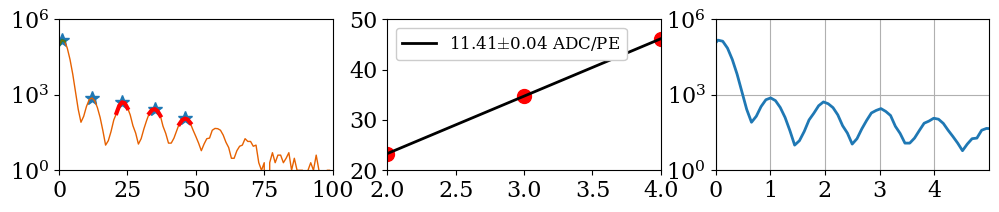

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.58OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


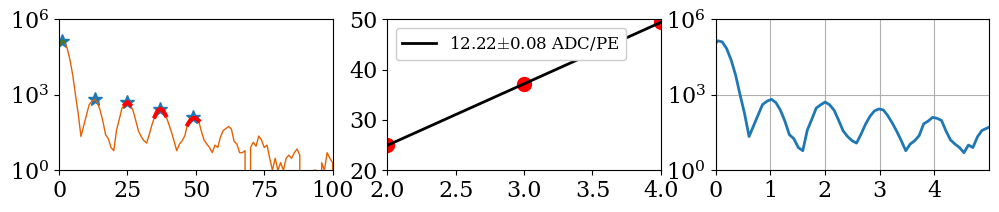

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.78OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


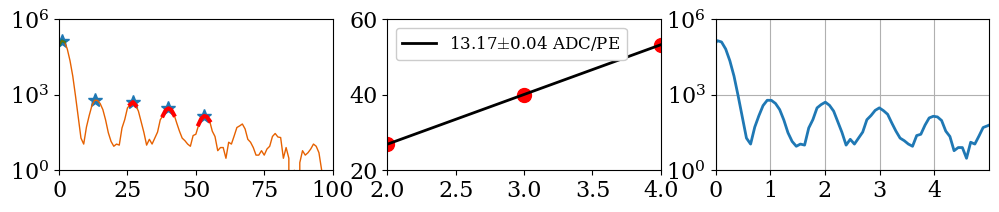

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_29.98OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


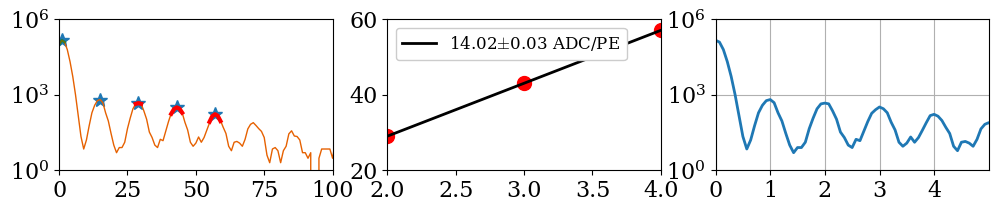

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.18OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


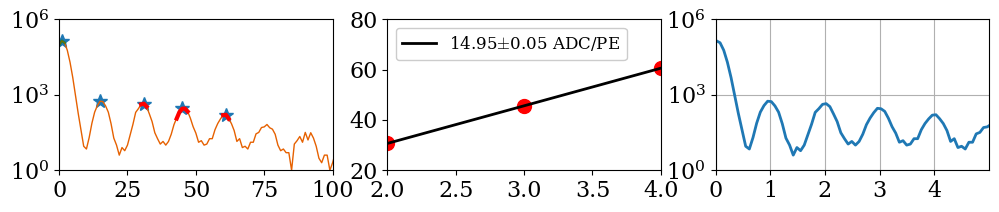

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


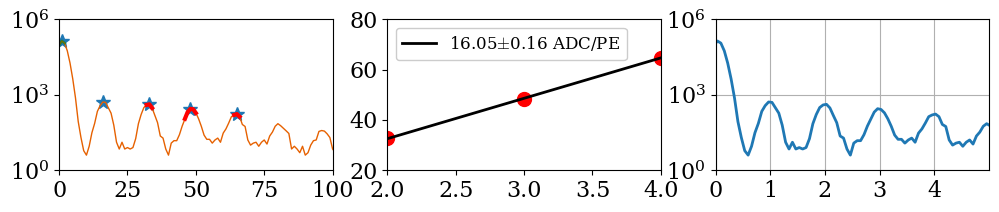

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.58OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


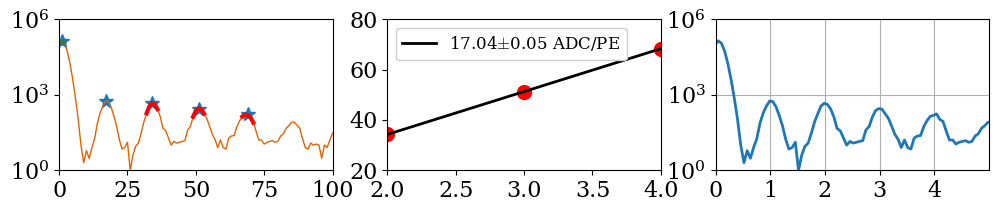

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.78OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


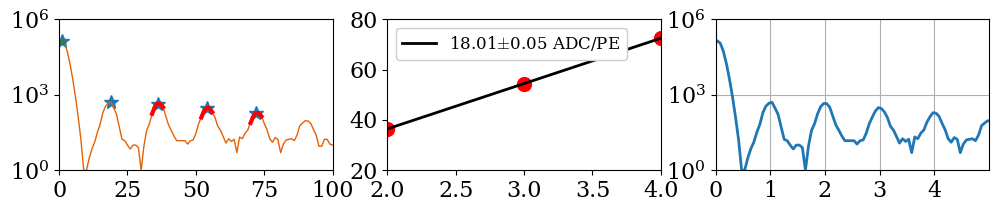

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_30.98OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


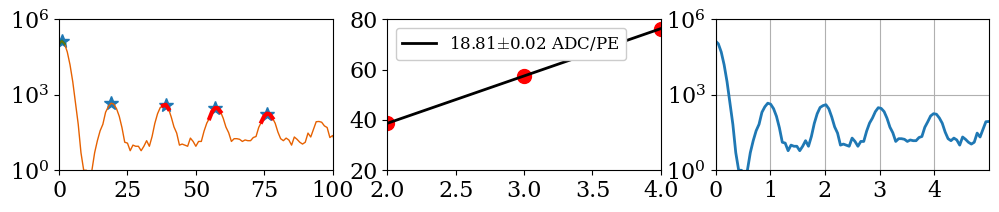

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_31.18OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


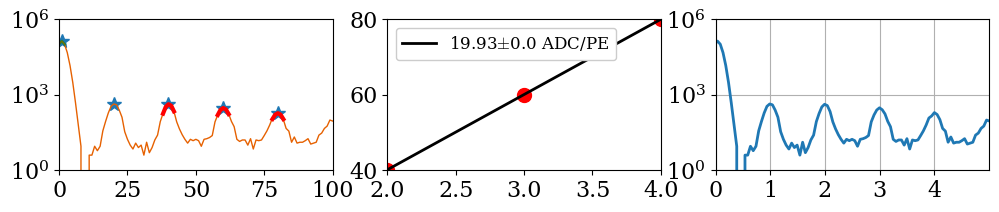

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_-109C_setpoint/mca_keith_31.38OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


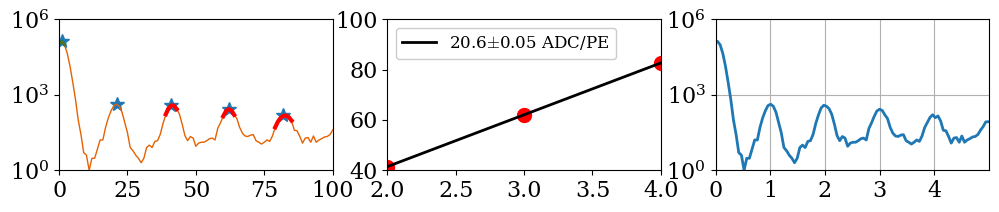

In [11]:
LXe_Full_NEG109C_setpoint_calib_pe,LXe_Full_NEG109C_setpoint_calib_count,LXe_Full_NEG109C_setpoint_gain_list,LXe_Full_NEG109C_setpoint_gain_err=gain_calculator(LXe_Full_NEG109C_setpoint,40,4)
Voltages_LXe_Full_NEG109C_setpoint=Voltages(LXe_Full_NEG109C_setpoint)

In [12]:
# LXe_Full_Source_Gain_after_0V_calib_pe,LXe_Full_Source_Gain_after_0V_calib_count,LXe_Full_Source_Gain_after_0V_gain_list,LXe_Full_Source_Gain_after_0V_gain_err=gain_calculator(LXe_Full_Source_Gain_after_0V,50,3)
# # gain_calculator(LXe_Full_Source_Gain_after_0V,1,1)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.00OV_0.h5


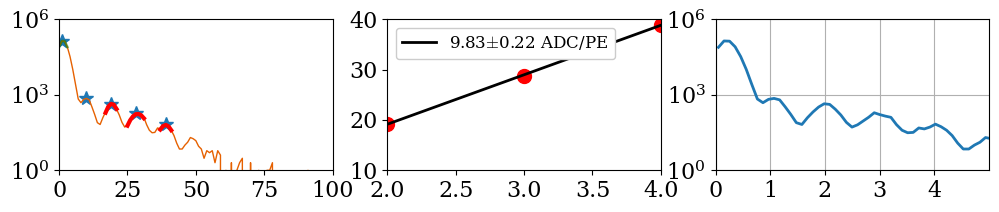

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.20OV_0.h5


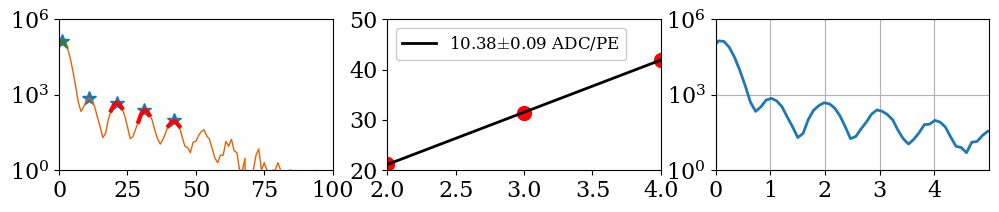

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


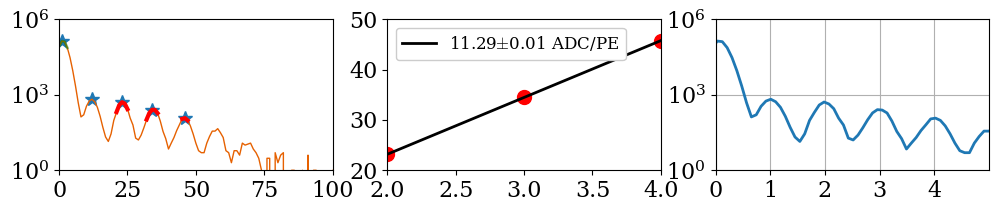

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.60OV_0.h5


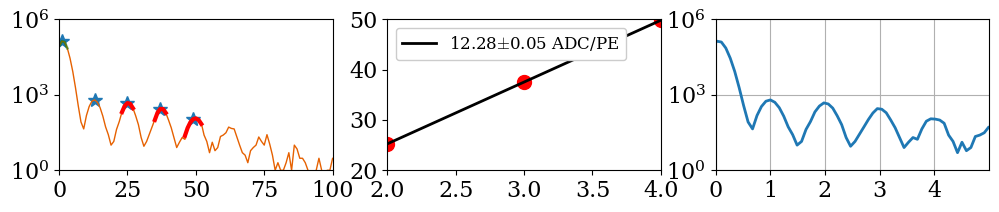

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_29.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


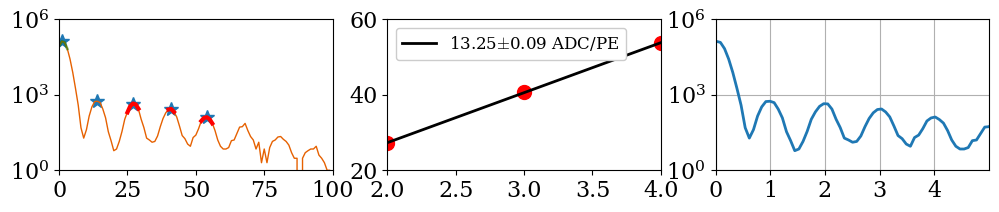

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.00OV_0.h5


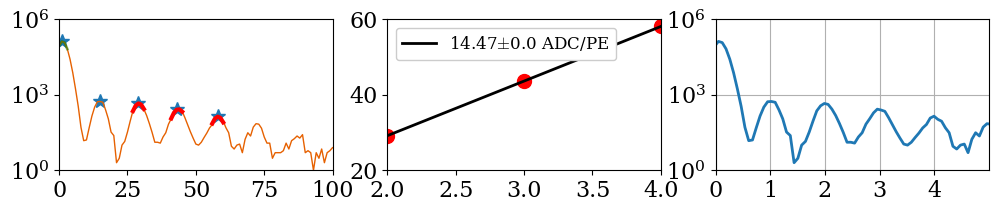

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


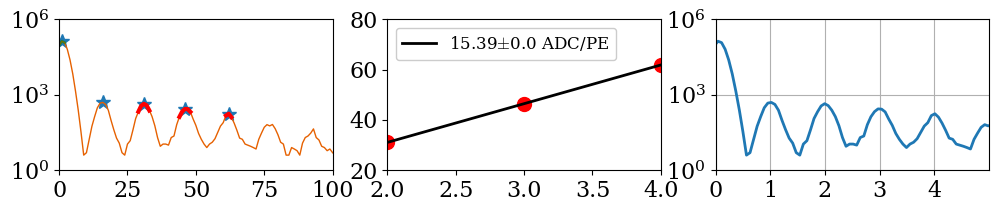

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


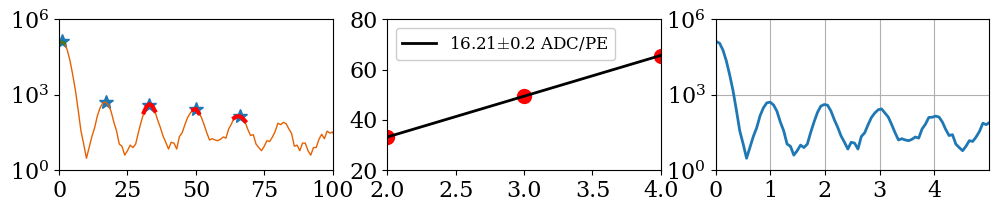

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


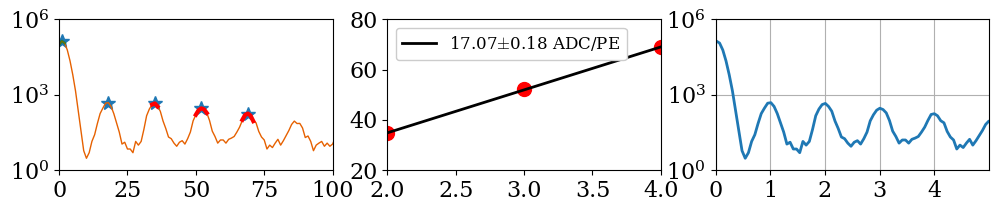

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


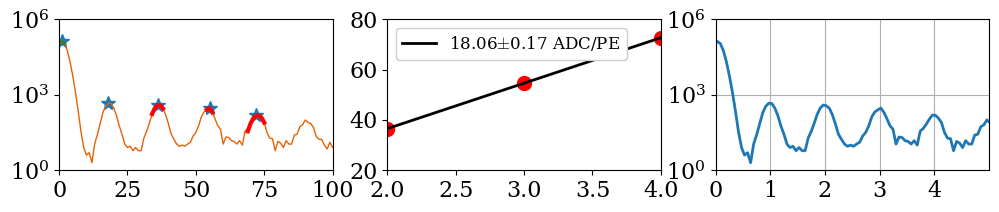

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_Source_Removed_Gain_after_0V/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


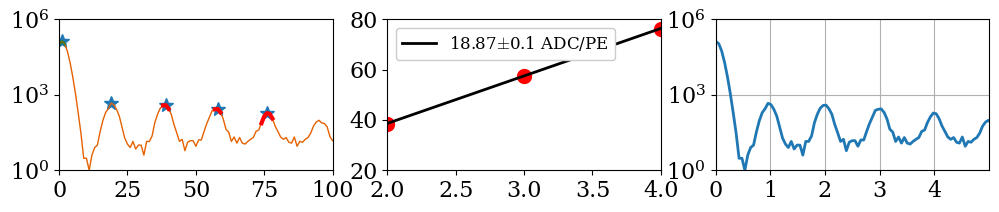

In [13]:
LXe_Full_Source_Removed_Gain_after_0V_calib_pe,LXe_Full_Source_Removed_Gain_after_0V_calib_count,LXe_Full_Source_Removed_Gain_after_0V_gain_list,LXe_Full_Source_Removed_Gain_after_0V_gain_err=gain_calculator(LXe_Full_Source_Removed_Gain_after_0V,40,4)
Voltages_Full_Source_Removed_Gain_after_0V=Voltages(LXe_Full_Source_Removed_Gain_after_0V)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


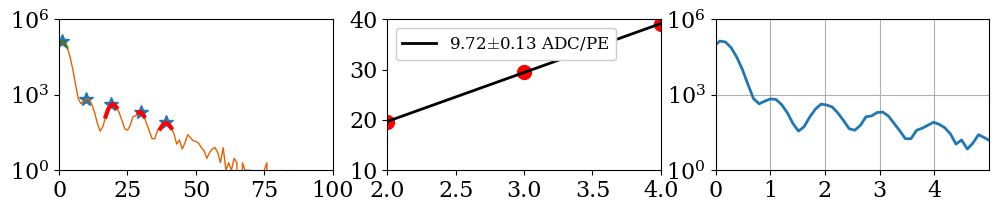

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.20OV_0.h5


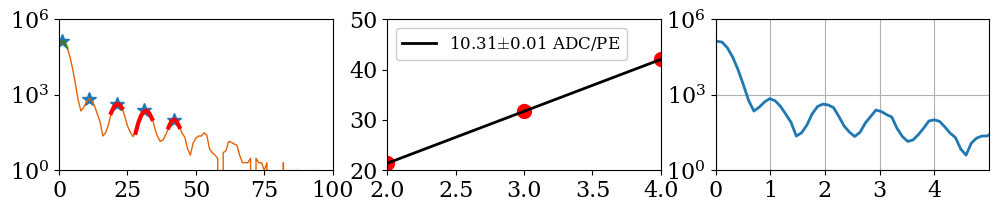

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.40OV_0.h5


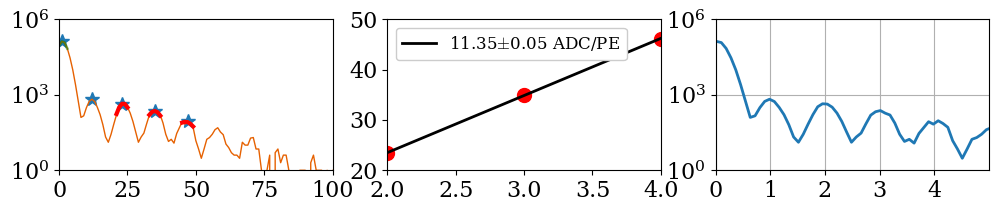

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


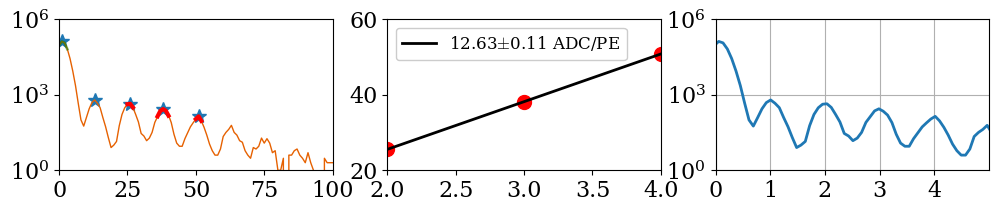

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_29.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


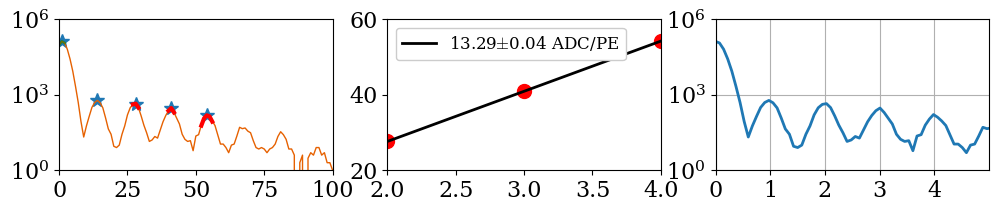

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


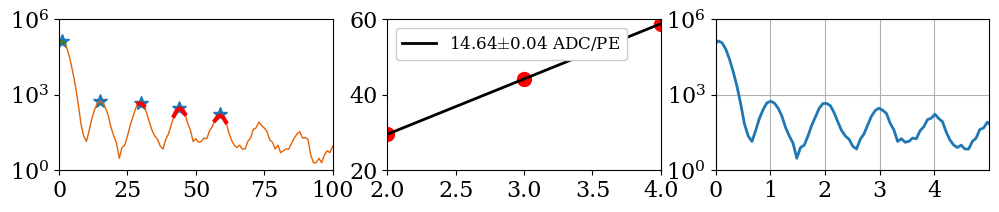

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


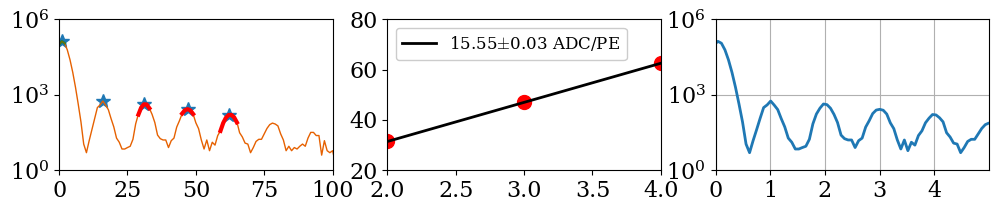

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


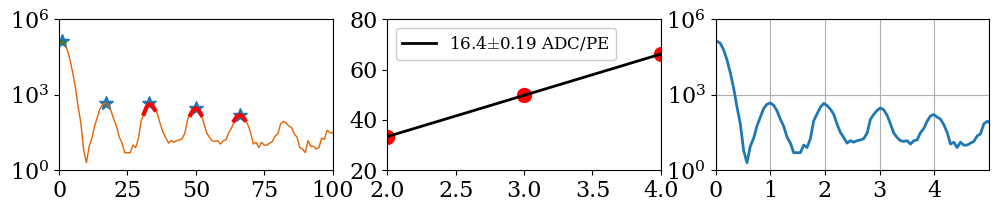

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


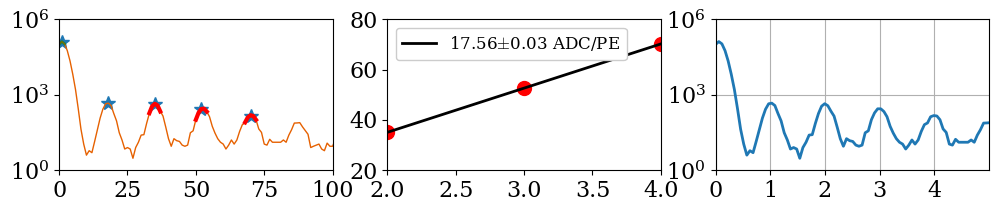

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


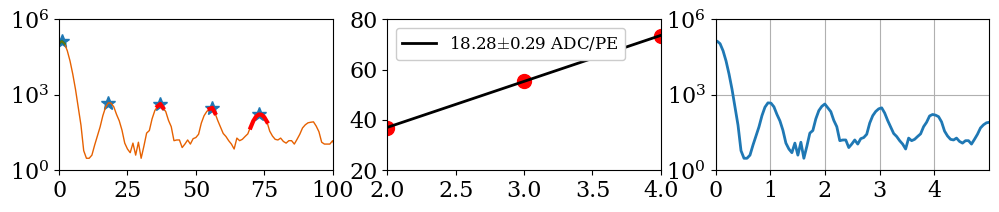

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


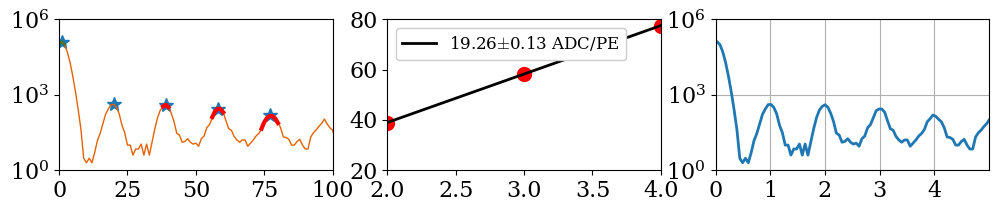

In [14]:
LXe_Full_E_field_2kV_Gain_calib_pe,LXe_Full_E_field_2kV_Gain_calib_count,LXe_Full_E_field_2kV_Gain_gain_list,LXe_Full_E_field_2kV_Gain_gain_err=gain_calculator(LXe_Full_E_field_2kV_Gain,40,4)
Voltages_LXe_Full_E_field_2kV_Gain=Voltages(LXe_Full_E_field_2kV_Gain)

In [15]:
# LXe_Full_E_field_2kV_source_reposition_Gain_calib_pe,LXe_Full_E_field_2kV_source_reposition_Gain_calib_count,LXe_Full_E_field_2kV_source_reposition_Gain_gain_list,LXe_Full_E_field_2kV_source_reposition_Gain_gain_err=gain_calculator(LXe_Full_E_field_2kV_source_reposition_Gain,100,4)
# gain_calculator(LXe_Full_E_field_2kV_source_reposition_Gain,50,4)

In [16]:
# LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure_calib_pe,LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure_calib_count,LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure_gain_list,LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure_gain_err=gain_calculator(LXe_Full_E_field_2kV_source_reposition_Gain_after_exposure,10,4)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.00OV_0.h5


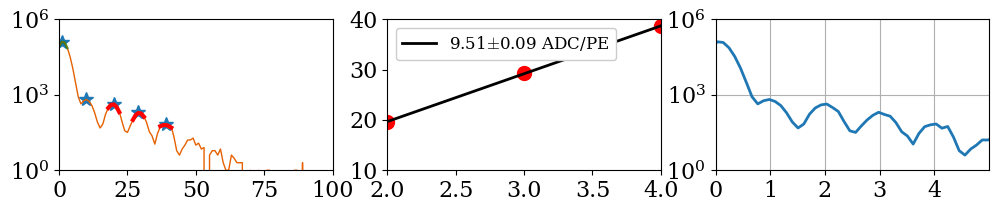

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


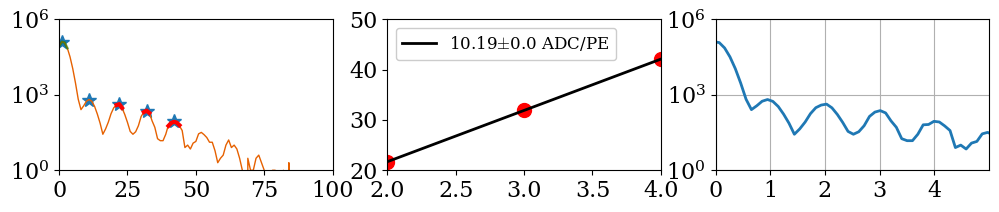

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


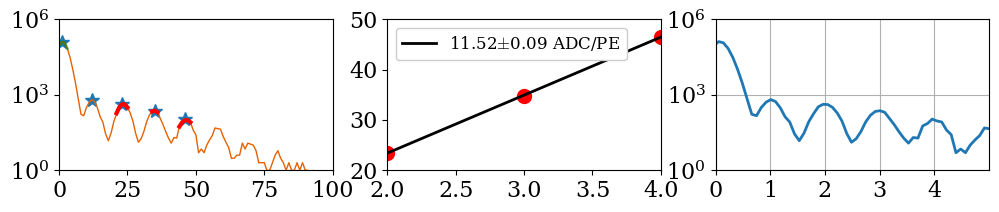

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


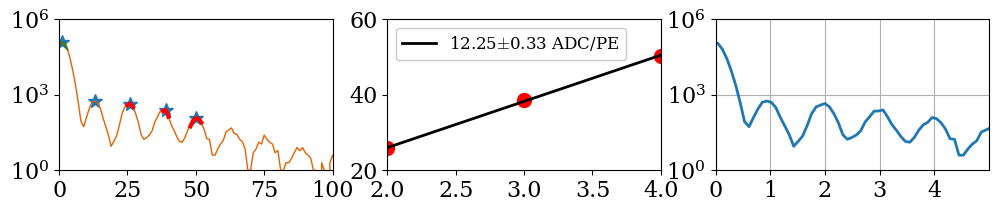

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_29.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


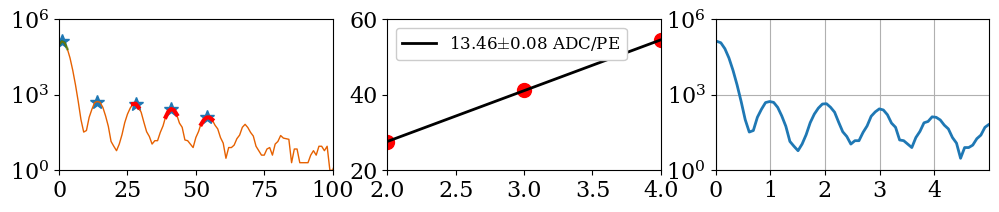

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


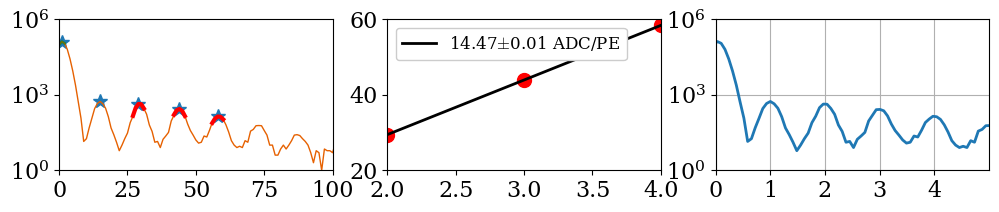

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


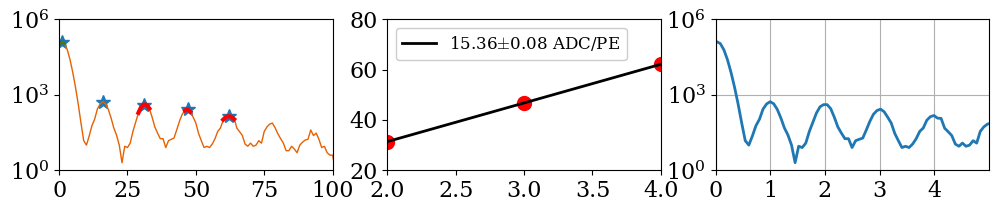

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


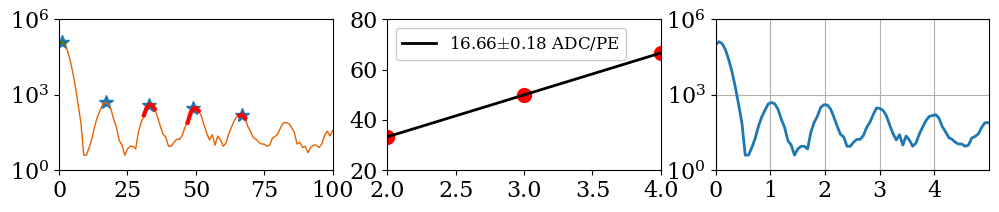

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


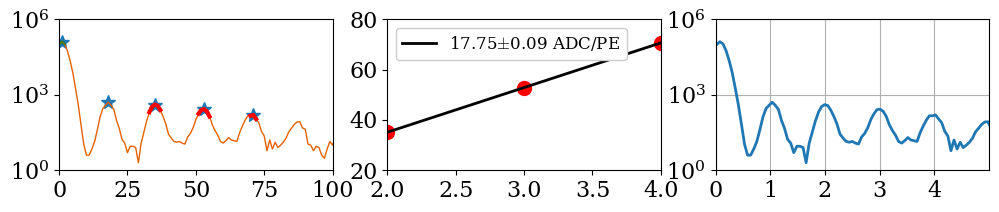

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


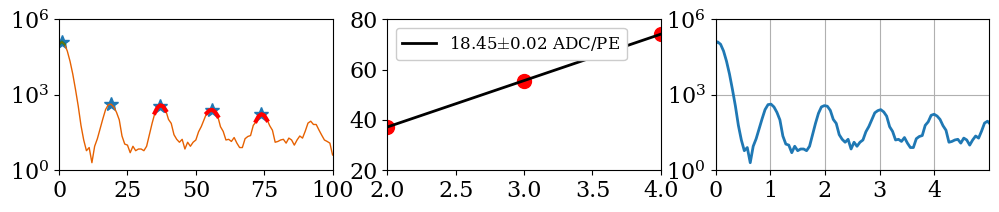

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_2kV_Gain_source_removed/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


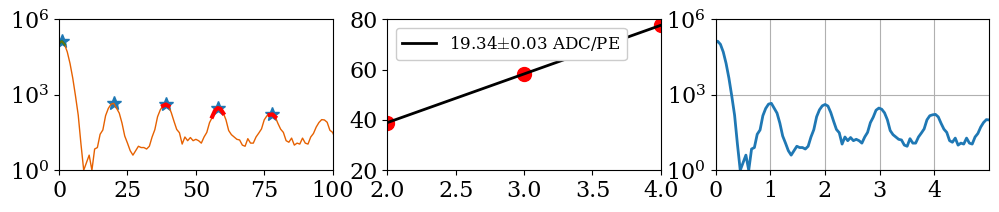

In [17]:
LXe_Full_E_field_2kV_Gain_source_removed_calib_pe,LXe_Full_E_field_2kV_Gain_source_removed_calib_count,LXe_Full_E_field_2kV_Gain_source_removed_gain_list,LXe_Full_E_field_2kV_Gain_source_removed_gain_err=gain_calculator(LXe_Full_E_field_2kV_Gain_source_removed,40,4)
Voltages_LXe_Full_E_field_2kV_Gain_source_removed=Voltages(LXe_Full_E_field_2kV_Gain_source_removed)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


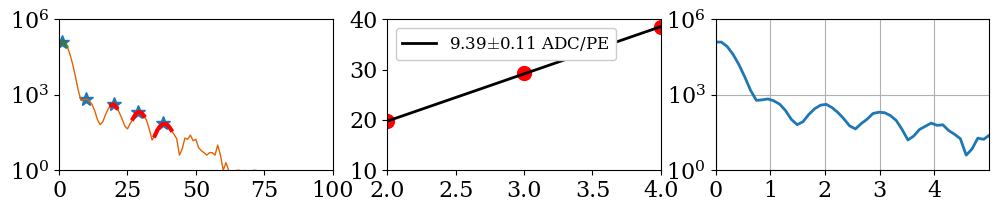

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.20OV_0.h5


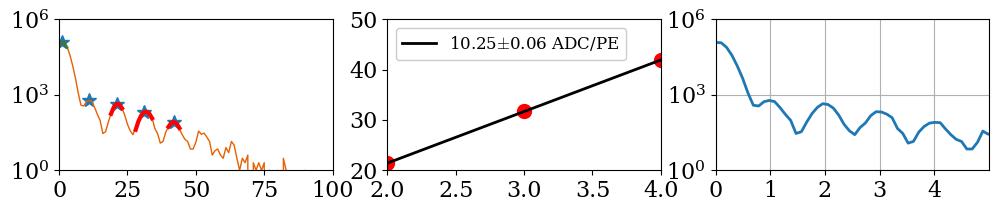

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.40OV_0.h5


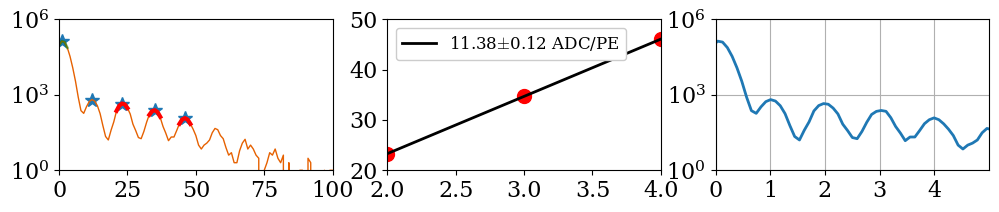

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


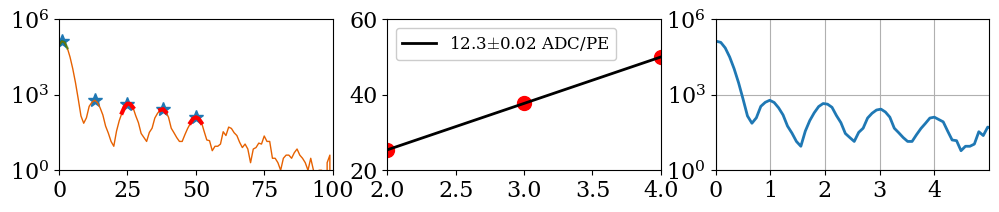

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_29.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


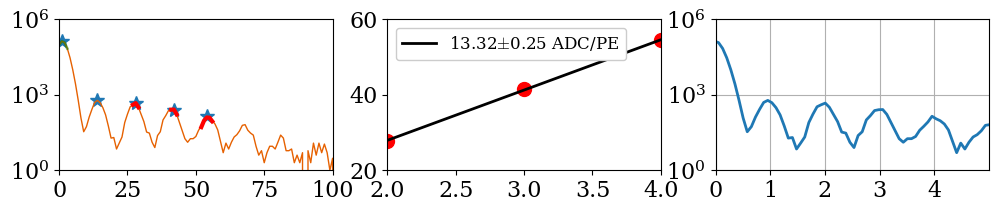

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


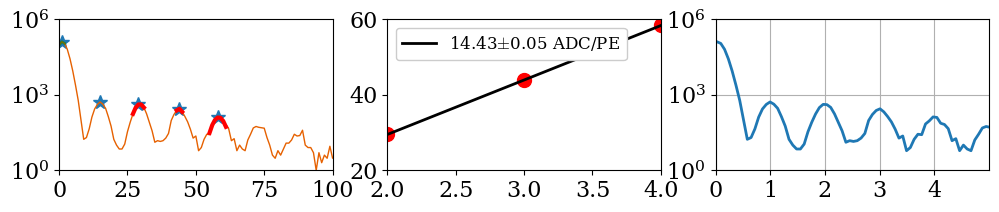

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


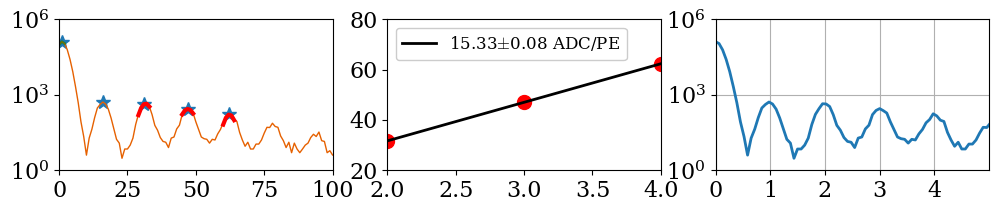

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


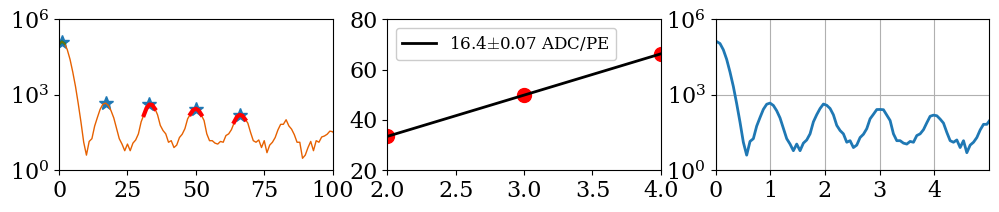

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


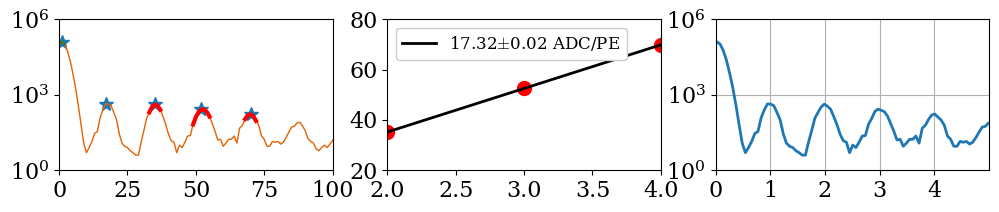

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


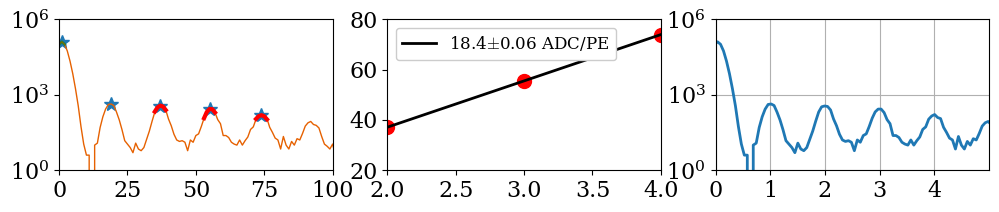

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


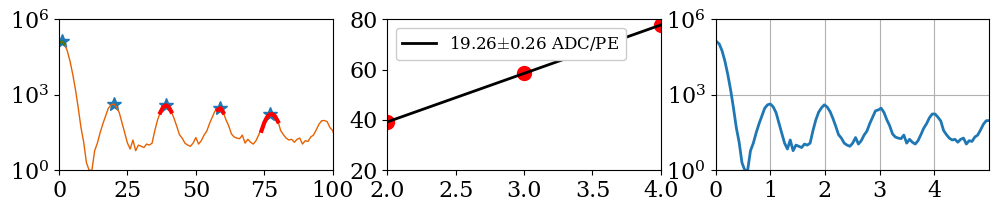

In [18]:
LXe_Full_E_field_NEG2kV_Gain_source_removed_calib_pe,LXe_Full_E_field_NEG2kV_Gain_source_removed_calib_count,LXe_Full_E_field_NEG2kV_Gain_source_removed_gain_list,LXe_Full_E_field_NEG2kV_Gain_source_removed_gain_err=gain_calculator(LXe_Full_E_field_NEG2kV_source_reposition_Gain_source_removed,40,4)
Voltages_LXe_Full_E_field_NEG2kV_Gain_source_removed=Voltages(LXe_Full_E_field_NEG2kV_source_reposition_Gain_source_removed)

In [19]:
print(Voltages_LXe_Full_E_field_NEG2kV_Gain_source_removed)

['29.00' '29.20' '29.40' '29.60' '29.80' '30.00' '30.20' '30.40' '30.60'
 '30.80' '31.00']


In [20]:
# LXe_Full_E_field_NEG2kV_source_gain_after_calib_pe,LXe_Full_E_field_NEG2kV_source_gain_after_calib_count,LXe_Full_E_field_NEG2kV_source_gain_after_gain_list,LXe_Full_E_field_NEG2kV_source_gain_after_gain_err=gain_calculator(LXe_Full_E_field_NEG2kV_source_gain_after,100,4)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


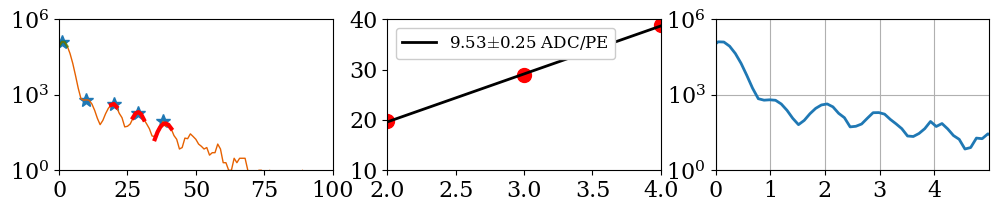

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


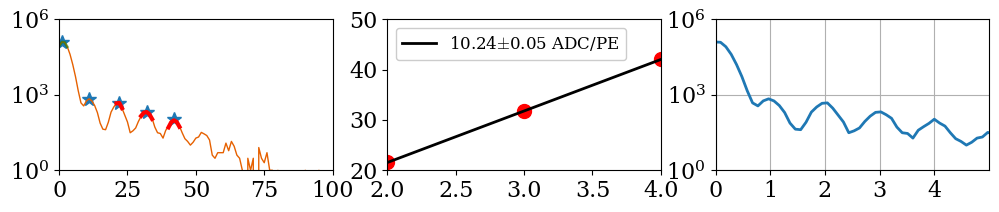

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


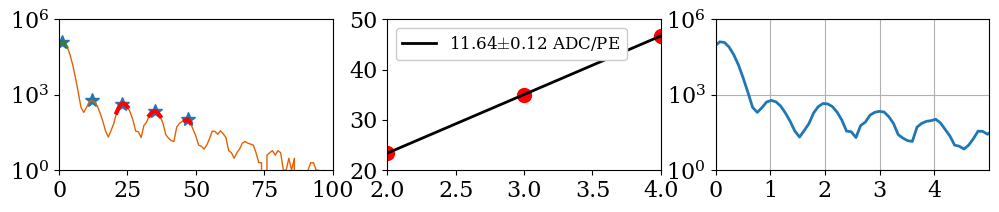

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.60OV_0.h5


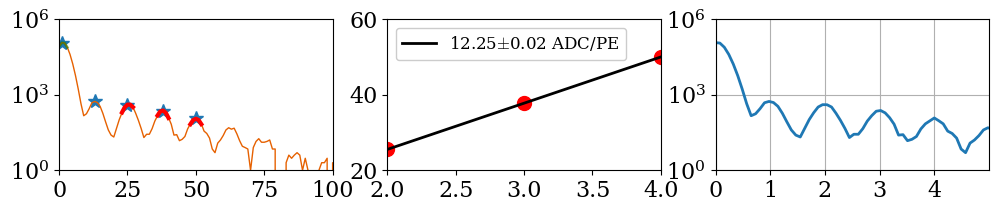

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_29.80OV_0.h5


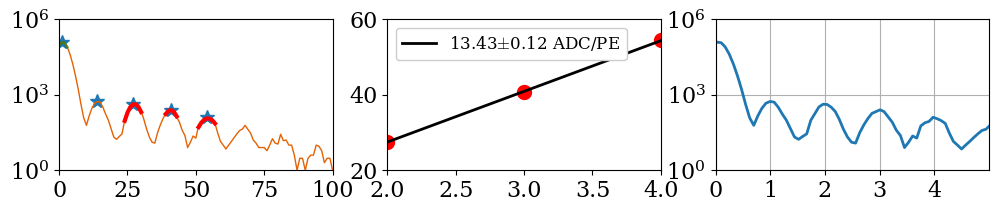

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


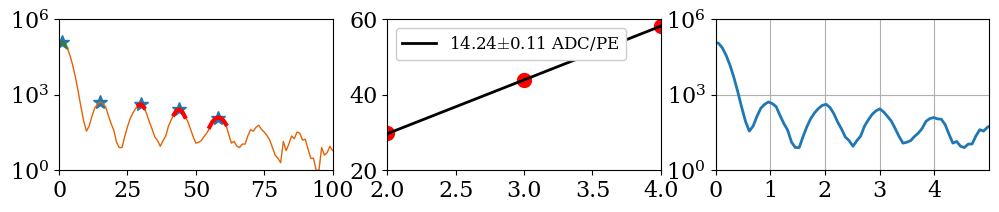

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.20OV_0.h5


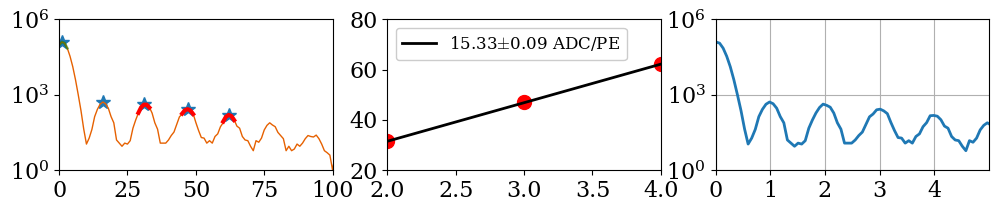

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


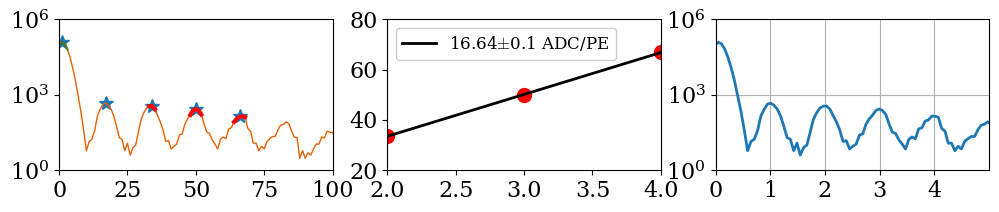

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.60OV_0.h5


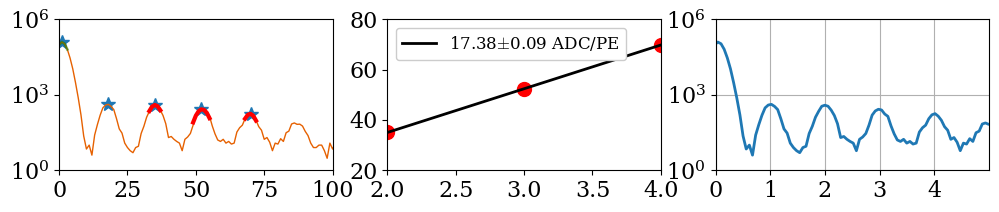

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


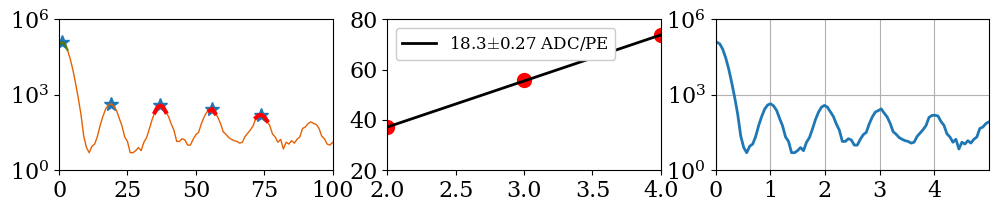

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_LED_gain_after/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


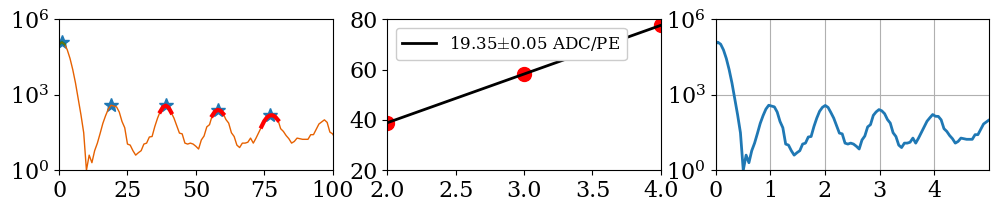

In [21]:
LXe_Full_E_field_NEG2kV_LED_gain_after_calib_pe,LXe_Full_E_field_NEG2kV_LED_gain_after_calib_count,LXe_Full_E_field_NEG2kV_LED_gain_after_gain_list,LXe_Full_E_field_NEG2kV_LED_gain_after_gain_err=gain_calculator(LXe_Full_E_field_NEG2kV_LED_gain_after,40,4)
Voltages_LXe_Full_E_field_NEG2kV_LED_gain_after=Voltages(LXe_Full_E_field_NEG2kV_LED_gain_after)

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


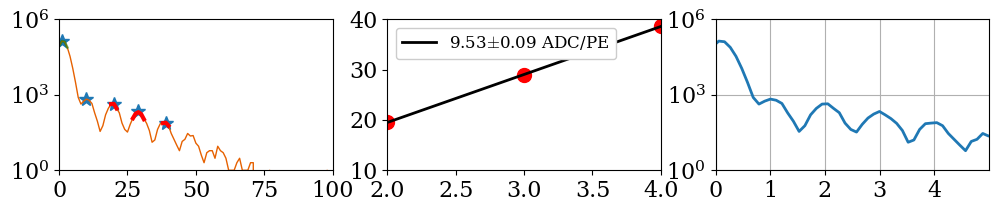

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


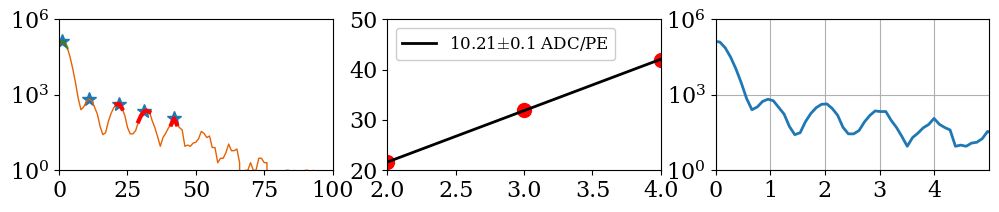

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


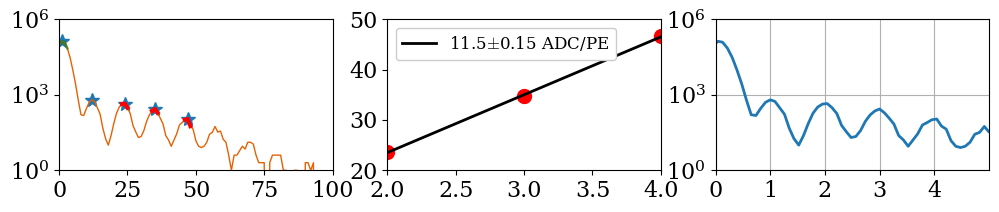

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


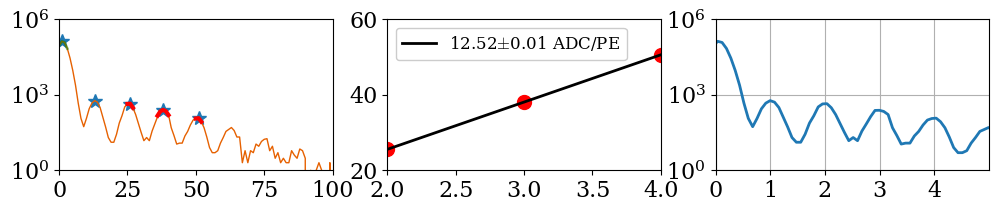

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_29.80OV_0.h5


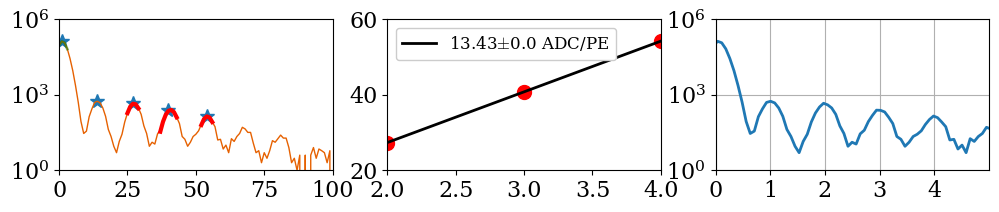

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


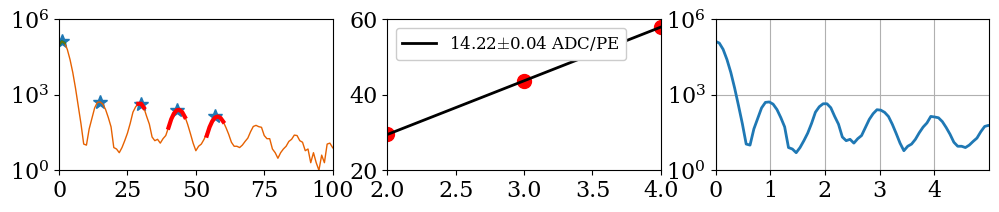

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.20OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


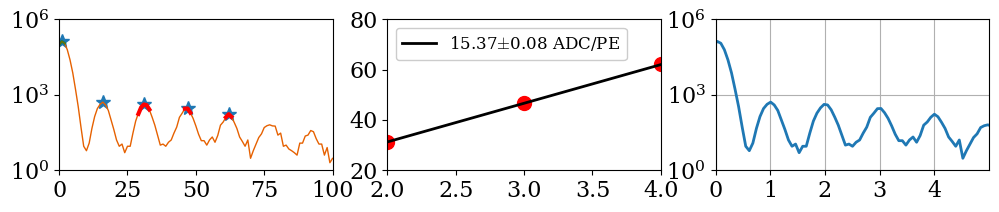

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.40OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


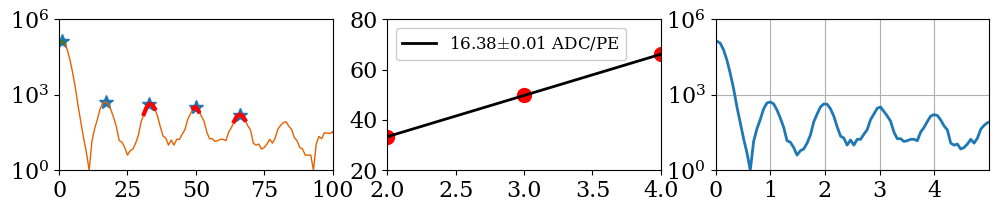

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.60OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


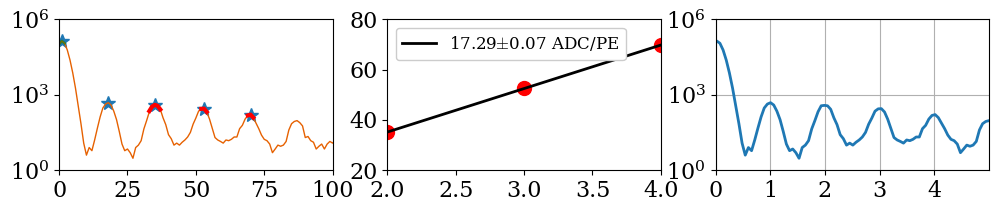

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_30.80OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


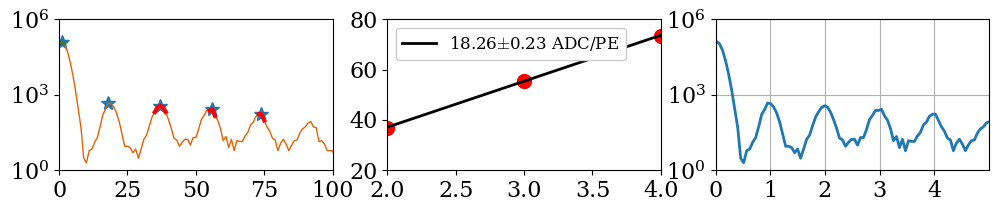

/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_LED_gain_final/mca_keith_31.00OV_0.h5


/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/gpfs/loomis/project/david_moore/ab2935/conda_envs/new_env/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


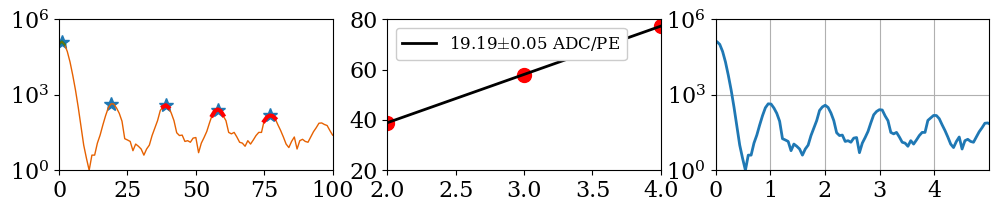

In [22]:
LXe_Full_LED_gain_final_calib_pe,LXe_Full_LED_gain_final_calib_count,LXe_Full_LED_gain_final_gain_list,LXe_Full_LED_gain_final_gain_err=gain_calculator(LXe_Full_LED_gain_final,40,4)
Voltages_LXe_Full_LED_gain_final=Voltages(LXe_Full_LED_gain_final)

In [23]:
print(Voltages_Full_Source_Removed_Gain_after_0V)

['29.00' '29.20' '29.40' '29.60' '29.80' '30.00' '30.20' '30.40' '30.60'
 '30.80' '31.00']


In [24]:
print(Voltages_LXe_Full_NEG109C_setpoint)

['29.38' '29.58' '29.78' '29.98' '30.18' '30.38' '30.58' '30.78' '30.98'
 '31.18' '31.38']


In [25]:
Bins=40

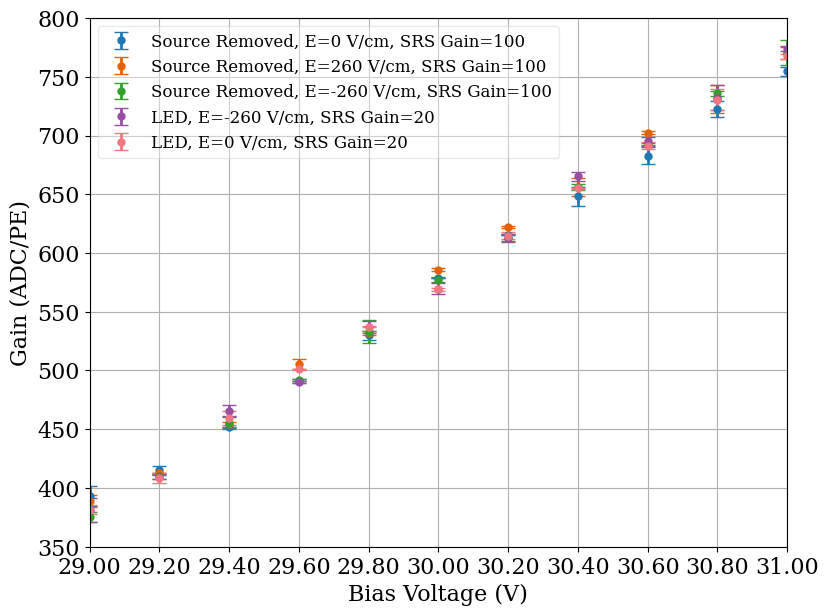

In [26]:
plt.figure(figsize=(9,7))
# plt.errorbar(Voltages_LXe_Full_NEG109C_setpoint,LXe_Full_NEG109C_setpoint_gain_list*Bins,yerr=LXe_Full_NEG109C_setpoint_gain_err*Bins,label='10 minutes after fill end',fmt='o',ms=5)

plt.errorbar(Voltages_Full_Source_Removed_Gain_after_0V,LXe_Full_Source_Removed_Gain_after_0V_gain_list*Bins,yerr=LXe_Full_Source_Removed_Gain_after_0V_gain_err*Bins,label='Source Removed, E=0 V/cm, SRS Gain=100',fmt='o',ms=5)
plt.errorbar(Voltages_LXe_Full_E_field_2kV_Gain,LXe_Full_E_field_2kV_Gain_gain_list*Bins,yerr=LXe_Full_E_field_2kV_Gain_gain_err*Bins,label='Source Removed, E=260 V/cm, SRS Gain=100',fmt='o',ms=5)
# plt.errorbar(Voltages_LXe_Full_E_field_2kV_Gain_source_removed,LXe_Full_E_field_2kV_Gain_source_removed_gain_list*Bins,yerr=LXe_Full_E_field_2kV_Gain_source_removed_gain_err*Bins,label='LXe_Full_E_field_2kV_Gain_source_removed',fmt='o',ms=5)
plt.errorbar(Voltages_LXe_Full_E_field_NEG2kV_Gain_source_removed,LXe_Full_E_field_NEG2kV_Gain_source_removed_gain_list*Bins,yerr=LXe_Full_E_field_NEG2kV_Gain_source_removed_gain_err*Bins,label='Source Removed, E=-260 V/cm, SRS Gain=100',fmt='o',ms=5)
plt.errorbar(Voltages_LXe_Full_E_field_NEG2kV_LED_gain_after,LXe_Full_E_field_NEG2kV_LED_gain_after_gain_list*Bins,yerr=LXe_Full_E_field_NEG2kV_LED_gain_after_gain_err*Bins,label='LED, E=-260 V/cm, SRS Gain=20',fmt='o',ms=5)
plt.errorbar(Voltages_LXe_Full_LED_gain_final,LXe_Full_LED_gain_final_gain_list*Bins,yerr=LXe_Full_LED_gain_final_gain_err*Bins,label='LED, E=0 V/cm, SRS Gain=20',fmt='o',ms=5)
# plt.xticks(np.linspace(28,32,8))
plt.grid()

# popt_0,pcov_0=curve_fit(line,volts,gain_list_0V,p0=[31,27],sigma=gain_err_0V)
# label = 'BV= '+str(np.round(popt_0[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_0)[1]),2))+' V'
# plt.plot(x_data, line(x_data,*popt_0), color=colors[1], ls='--', label=label)
# plt.plot(x_data,line(x_data,*popt_260),color=colors[1],label='BV= '+str(np.round(popt_260[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov_260)[1]),2))+' V',ls='--')
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.legend(loc='best',framealpha=0.4)
plt.savefig('Gain_in_between.pdf')
plt.show()